<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - Neural Network <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Ali Nazari
### Student Number : 99102401
___

# Problem
In this assignment our goal is to develop a framework for simple neural networks, multi layer perceptrons. We are going to use only `numpy` and no other packages to build our own classes and network.

# Setup

In [105]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import tqdm
import copy
from utils import *

plt.style.use('ggplot')

# Section 1: Modules implementation (65 Points)
We are going to implement required modules for a neural net. Each of this modules must implement the neccessery functions, `_forward` and `backward`. In the following parts, we will implement `LinearLayer`, `ReLU` and `SoftMax` layers.

## Layers

#### Linear Layer (10 Points)

In [106]:
class LinearLayer(Module):
    """
    A linear layer module which calculate (Wx + b).
    """

    def __init__(self, dim_in, dim_out, initializer, reg, alpha):
        """
        Args:
            - dim_in: input dimension,
            - dim_out: output dimension,
            - initializer: a function which get (dim_in, dim_out) and initialize
                a [dim_in x dim_out] matrix,
            - reg: L2-regularization flag
            - alpha: L2-regularization coefficient
        """
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.reg = reg
        self.alpha = alpha
        self.params = {
            'W': initializer(dim_in, dim_out),
            'b': initializer(1, dim_out).reshape(dim_out)
        }
        self.grads = dict()
        self.cache = dict()

    def _forward(self, x):
        """
        linear forward function, calculate Wx+b for a batch of data

        Args:
            x : a batch of data

        Note:
            you need to store some values in cache to be able to
            calculate backward path.
        """
        y = np.zeros((len(x), self.dim_out))
        for i in range(len(x)):
            y[i] = np.dot(self.params['W'], x[i])
            y[i] += self.params['b']
        self.cache['x'] = x
        self.cache['y'] = y
        return y

    def backward(self, upstream):
        """
        get upstream gradient and returns downstream gradient

        Args:
            upstream : upstream gradient of loss w.r.t module output

        Note:
            you need to calculate gradient of loss w.r.t module input
            and parameters and store them in grads.
        """
        grad_w = np.zeros((len(self.cache['x']), self.dim_out, self.dim_in))
        grad_x = np.zeros((len(self.cache['x']), self.dim_in))
        for i in range(len(self.cache['x'])):
            grad_w[i] = np.dot(upstream[i].reshape(upstream[i].shape[0], 1), self.cache['x'][i].reshape(self.dim_in, 1).T)
            grad_x[i] = np.dot(self.params['W'].T, upstream[i])
        self.grads = {
            'W': grad_w,
            'b': 1.0 * upstream,
            'x': grad_x,
            'reg': self.alpha * self.params['W'] if self.reg else 0
        }

In [107]:
# sanity check, output must be from o(e-5)
initializer = lambda x, y: np.random.normal(size=(y, x))
linear = LinearLayer(5, 10, initializer, reg=True, alpha=0.001)
check_gradient_linear(linear, h=0.00001)

Gradient of loss w.r.t output:
[[0.82955535 0.21114721 0.29056745 0.76196253 0.48381119 0.26313752
  0.17058744 0.68924104 0.14521547 0.36108282]
 [0.17969557 0.61131998 0.90547691 0.09465278 0.04351438 0.82898441
  0.53347611 0.25746229 0.83709683 0.91589097]
 [0.95338569 0.53886974 0.68147718 0.14543317 0.36605854 0.25725115
  0.64065521 0.99467217 0.84735271 0.6116583 ]
 [0.6585274  0.09264464 0.55180917 0.84839143 0.74920247 0.66146217
  0.48228694 0.96546312 0.48159736 0.23890255]
 [0.62490249 0.71391215 0.39654666 0.08349731 0.25206548 0.14235356
  0.84943899 0.30579129 0.18025764 0.72632517]
 [0.07006783 0.77688796 0.90754448 0.97929669 0.15398316 0.39885902
  0.85437948 0.42579468 0.34963434 0.91473698]
 [0.92071169 0.33599422 0.31872931 0.63541889 0.58434891 0.17077758
  0.11395208 0.59733395 0.64102327 0.2976854 ]
 [0.36232214 0.94163488 0.10551311 0.04220206 0.55321597 0.03134844
  0.82945429 0.71557495 0.4421455  0.89943093]
 [0.15358404 0.01888662 0.93738637 0.70363497 0.2

#### ReLU Layer (5 Points)

In [108]:
class ReLU(Module):
    """
    Rectified Linear Unit function
    """

    def __init__(self):
        self.cache = dict()
        self.grads = dict()

    def _forward(self, x):
        """
        applies relu function on x

        Args:
            x : a batch of data

        Returns:
            y : relu of input
        """
        y = list()
        for i in range(x.shape[0]):
          y.append([])
          for j in range(x.shape[1]):
            if x[i][j] < 0:
              y[-1].append(0)
            else:
              y[-1].append(x[i][j])
        y = np.asarray(y)
        self.cache['x'] = x
        return y

    def backward(self, upstream):
        """
        calculate and store gradient of loss w.r.t module input

        Args:
            upstream : gradient of loss w.r.t modele output
        """
        x = self.cache['x']
        grad_x = list()
        for i in range(x.shape[0]):
          grad_x.append([])
          for j in range(x.shape[1]):
            if x[i][j] < 0:
              grad_x[-1].append(0)
            else:
              grad_x[-1].append(upstream[i][j])
        grad_x = np.asarray(grad_x)
        self.grads['x'] = grad_x

In [109]:
# sanity check - output must be from o(e-8)
relu = ReLU()
check_gradient_relu(relu)

Gradient of loss w.r.t output:
[[0.0584373  0.88325126 0.26846461 0.89464548 0.50320908]
 [0.09177401 0.38804983 0.72265477 0.53096799 0.3455338 ]
 [0.24378035 0.21950653 0.93640053 0.87820106 0.33644566]
 [0.87531923 0.36254974 0.54245228 0.95475059 0.96677731]
 [0.52121319 0.0189511  0.32733035 0.67793154 0.20010495]
 [0.7436883  0.46844046 0.26309046 0.4595906  0.83244012]
 [0.62944357 0.72287473 0.73348264 0.21539666 0.77413853]
 [0.20357441 0.51746258 0.75884962 0.6687436  0.51406511]
 [0.71992879 0.77988594 0.72842911 0.12522849 0.8795159 ]
 [0.64932805 0.24568954 0.25430494 0.42654584 0.25253977]]
Gradient of loss w.r.t input:
[[0.         0.88325126 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.93640053 0.         0.33644566]
 [0.87531923 0.36254974 0.         0.         0.96677731]
 [0.52121319 0.0189511  0.         0.67793154 0.20010495]
 [0.         0.46844046 0.26309046 0.         0.        ]
 [0.629443

#### SoftMax Layer (15 Points)

We could have a layer that calculate softmax for us. In other word, for input $x\in\mathcal{R}^N$ it would return $y\in\mathcal{R}^n$ where $y_i = \frac{e^{x_i}}{\sum e^{x_i}}$. But this method is not numerical stable because $e^{x_i}$ in this formulation can get very large easly and return `nan`. Instead of that we will implement a logarithmic version of softmax which instead of calculating $\frac{e^{x_i}}{\sum e^{x_i}}$, we will calculate $\log\left(\frac{e^{x_i}}{\sum e^{x_i}}\right) = x_i - \log\sum e^{x_i}$. In order to calculate second term you can use `np.logaddexp` but this function only works on two input. For more than two input, fill in the following function to be able to calculate log sum exp of an array of shape (b,n). `axis=1` means sum over columns and `axis=0` sum over rows.

In [110]:
def logsumexp(array, axis=1):
    """
    calculate log(sum(exp(array))) using np.logaddexp

    Args:
        array : input array
        axis : reduce axis, 1 means columns and 0 means rows
    """
    return np.array(list(map(np.logaddexp.reduce, array))).reshape(array.shape[0])

In [111]:
class LogSoftMax(Module):
    def __init__(self):
        self.cache = dict()
        self.grads = dict()

    def _forward(self, x):
        """
        get x and calculate softmax of that.

        Args:
            x : batch of data with shape (b,m)

        Returns:
            y : log softmax of x with shape (b,m)
        """
        self.cache['x'] = x
        second_sigma_term = logsumexp(x, axis=1).reshape(x.shape[0], 1)
        return x - second_sigma_term

    def backward(self, upstream):
        """
        calculate gradient of loss w.r.t module input and save that in grads.

        Args:
            upstream : gradient of loss w.r.t module output with sahpe (b,m)
        """
        x = self.cache['x']
        exp_term = np.exp(x).T
        first_axis_sum = upstream.sum(axis=1)
        second_axis_sum = exp_term.sum(axis=0)
        seocnd_term = ((first_axis_sum/second_axis_sum)*exp_term)
        self.grads['x'] = upstream - seocnd_term.T

In [112]:
# sanity check, output must be from o(e-7)
sm = LogSoftMax()
check_gradient_softmax(sm)

Gradient of loss w.r.t output:
[[0.1630331  0.13488387 0.64710355 0.267412   0.38909318]
 [0.17558247 0.28087961 0.28324271 0.94903849 0.49365313]
 [0.66110396 0.48183119 0.81942941 0.72267524 0.05972474]
 [0.23687506 0.58419898 0.63517021 0.34454597 0.22345524]
 [0.88441083 0.96840966 0.22989379 0.11408372 0.45871137]
 [0.00832097 0.74025973 0.43923602 0.0739073  0.96269913]
 [0.17190485 0.1383921  0.6479173  0.88009471 0.35911365]
 [0.42453736 0.08015594 0.24649505 0.0371008  0.95956135]
 [0.14149331 0.25348514 0.93081829 0.36581357 0.52428419]
 [0.23683714 0.9252707  0.18926396 0.4527474  0.47814843]]
Gradient of loss w.r.t input:
[[-0.25543381 -0.14106689  0.41398    -0.12588516  0.10840584]
 [-0.20376161 -0.15868754 -0.08018071  0.43744502  0.00518484]
 [ 0.11956483  0.16874444  0.31243645 -0.01058303 -0.59016269]
 [-0.09121993  0.20407432  0.31101343  0.00085981 -0.42472763]
 [ 0.28037124  0.35101985 -0.11664377 -0.4851247  -0.02962261]
 [-0.29306479  0.21679663 -0.12605471 -0.46

## Model (10 Points)
We need a model class which gathers our layers togather and performs forward and backward on all of them.

In [113]:
class MLPModel(Module):
    """
    A multilayer neural network model
    """

    def __init__(self, layers):
        """
        Args:
            layers : list of model layers
        """
        self.layers = layers

    def _forward(self, x):
        """
        Perform forward on x

        Args:
            x : a batch of data

        Returns:
            o : model output
        """
        output = x
        for layer in self.layers:
            output = layer(output)
        return output
    
    def backward(self, upstream):
        """
        Perform backward path on whole model

        Args:
            upstream : gradient of loss w.r.t model output
        """
        counter = len(self.layers) - 1
        while counter >= 0:
          self.layers[counter].backward(upstream)
          upstream = self.layers[counter].grads['x']
          counter -= 1
            

    def get_parameters(self):
        """
        Returns:
            parametric_layers : all layers of model which have parameter
        """
        to_return = []
        for layer in self.layers:
            if hasattr(layer, 'params'):
                to_return.append(layer)
        return to_return

## Loss functions (10 Points)
We need to implement loss functions to be able to train our network. We will implement CrossEntropy loss function. But notice that we have implemented `LogSoftMax` in logarithmic way so input of the following class will be logarithm of probabilities. 

In [114]:
class CrossEntropyLoss(Module):
    def __init__(self, mean=False):
        self.mean = mean
        self.cache = dict()
        self.grads = dict()

    def _forward(self, logprobs, targets):
        """
        Calculate cross entropy of inputs.

        Args:
            probs : matrix of probabilities with shape (b,n)
            targets : list of samples classes with shape (b,)

        Returns:
            y : cross entropy loss
        """
        y = 0
        result = np.zeros(logprobs.shape)
        for i in range(targets.shape[0]):
            result[i] = (np.arange(logprobs.shape[1]) == targets[i]).astype(float)
            y -= np.sum(result[i] * logprobs)
        self.cache['y'] = result
        return y

    def backward(self, upstream):
        """
        Calculate gradient of loss w.r.t module input and save them in grads.

        Args:
            upstream : gradient of loss w.r.t module output (loss)
        """
        y = self.cache['y']
        result = np.zeros(y.shape)
        for i in range(y.shape[0]):
            result[i] = np.dot(-1 * y[i].T, upstream)
        self.grads['x'] = result

In [115]:
# check gradient, output must be from o(e-10)
ce = CrossEntropyLoss()
check_gradient_ce(ce, h=0.0001)

Gradient of loss w.r.t output:
1
Gradient of loss w.r.t input:
[[ 0. -1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.]
 [ 0. -1.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.]]
Relative error of delta-loss:
0.8181818181820201


## Optimization (15 Points)

Now that we have our network and loss function, we need to update model paremeters. We can do so by using `Optimizer` class that perform updating rule on model parameters. You need to implement `sgd` and `momentum` strategy for this optimizer. Becarefull to consider regularization update for linear units that require regularization.

In [116]:
class Optimizer():
    """
    Our main optimization class.
    
    You can add arguments to _sgd and _momentum function if you need to do so, and
    pass this arguments to step function when using optimizer. Don't change __init__
    or step function.
    """

    def __init__(self, layers, strategy, lr):
        """
        save layers here in order to update their parameters later.

        Args:
            layers : model layers (those that we want to update their parameters)
            strategy : optimization strategy
            lr : learning rate
        """
        self.layers = layers
        self.strategy = strategy
        self.lr = lr
        self.strategies = {
            'sgd': self._sgd,
            'momentum': self._momentum,
        }
        self.previous = dict()
        for layer in self.layers:
            self.previous[layer] = dict()
            for param in layer.params:
                self.previous[layer][param] = np.zeros(layer.params[param].shape)

    def step(self, *args):
        """
        Perform updating strategy on all layers paramters.
        """
        self.strategies[self.strategy](*args)

    def _sgd(self):
        """
        Perform sgd update on all parameters of layers
        """
        for layer in self.layers:
            for param in layer.params:
                layer.params[param] -= self.lr * (np.mean(layer.grads[param], axis=0).reshape(layer.params[param].shape) + np.mean(layer.grads['reg'], axis=0) if param == 'W' else 0)
    
    def _momentum(self):
        """
        Perform momentum update on all parameters of layers
        """
        for layer in self.layers:
            for param in layer.params:
                self.previous[layer][param] = 0.9 * self.previous[layer][param] + self.lr * (np.mean(layer.grads[param], axis=0).reshape(layer.params[param].shape) + np.mean(layer.grads['reg'], axis=0) if param == 'W' else 0)
                layer.params[param] -= self.previous[layer][param]

# Section 2: CIFAR-10 Classification (35 Points)

Now that we can build a neural network we want to solve CIFAR-10 classification problem. This dataset consists of 60000 $32 \times 32$ coloured images in 10 classes.

## Data preparation (5 Points)

In [117]:
!chmod 777 cifar10_downloader.bash

In [118]:
#################################################
##      Run this cell to download dataset      ##
##         the dataset is about 150 MB         ##
#################################################
!./cifar10_downloader.bash

In [119]:
#############################################
##      Run this cell to load dataset      ##
#############################################
data = load_dataset(train_num=4000, test_num=1000)

for k in data.keys():
    print(f'{k}: {data[k].shape}')

X_train: (4000, 32, 32, 3)
Y_train: (4000,)
X_test: (1000, 32, 32, 3)
Y_test: (1000,)


In [120]:
X_train, Y_train, X_val, Y_val = np.zeros((2500, 32, 32, 3)), np.zeros((2500)), np.zeros((500, 32, 32, 3)), np.zeros((500))
for i in range(2500):
  X_train[i] = data['X_train'][i]
  Y_train[i] = data['Y_train'][i]
for i in range(2500, 3000):
  X_val[i-2500] = data['X_train'][i]
  Y_val[i-2500] = data['Y_train'][i]
data['X_train'] = X_train
data['Y_train'] = Y_train
data['X_val'] = X_val
data['Y_val'] = Y_val
for k in data.keys():
    print(f'{k}: {data[k].shape}')

X_train: (2500, 32, 32, 3)
Y_train: (2500,)
X_test: (1000, 32, 32, 3)
Y_test: (1000,)
X_val: (500, 32, 32, 3)
Y_val: (500,)


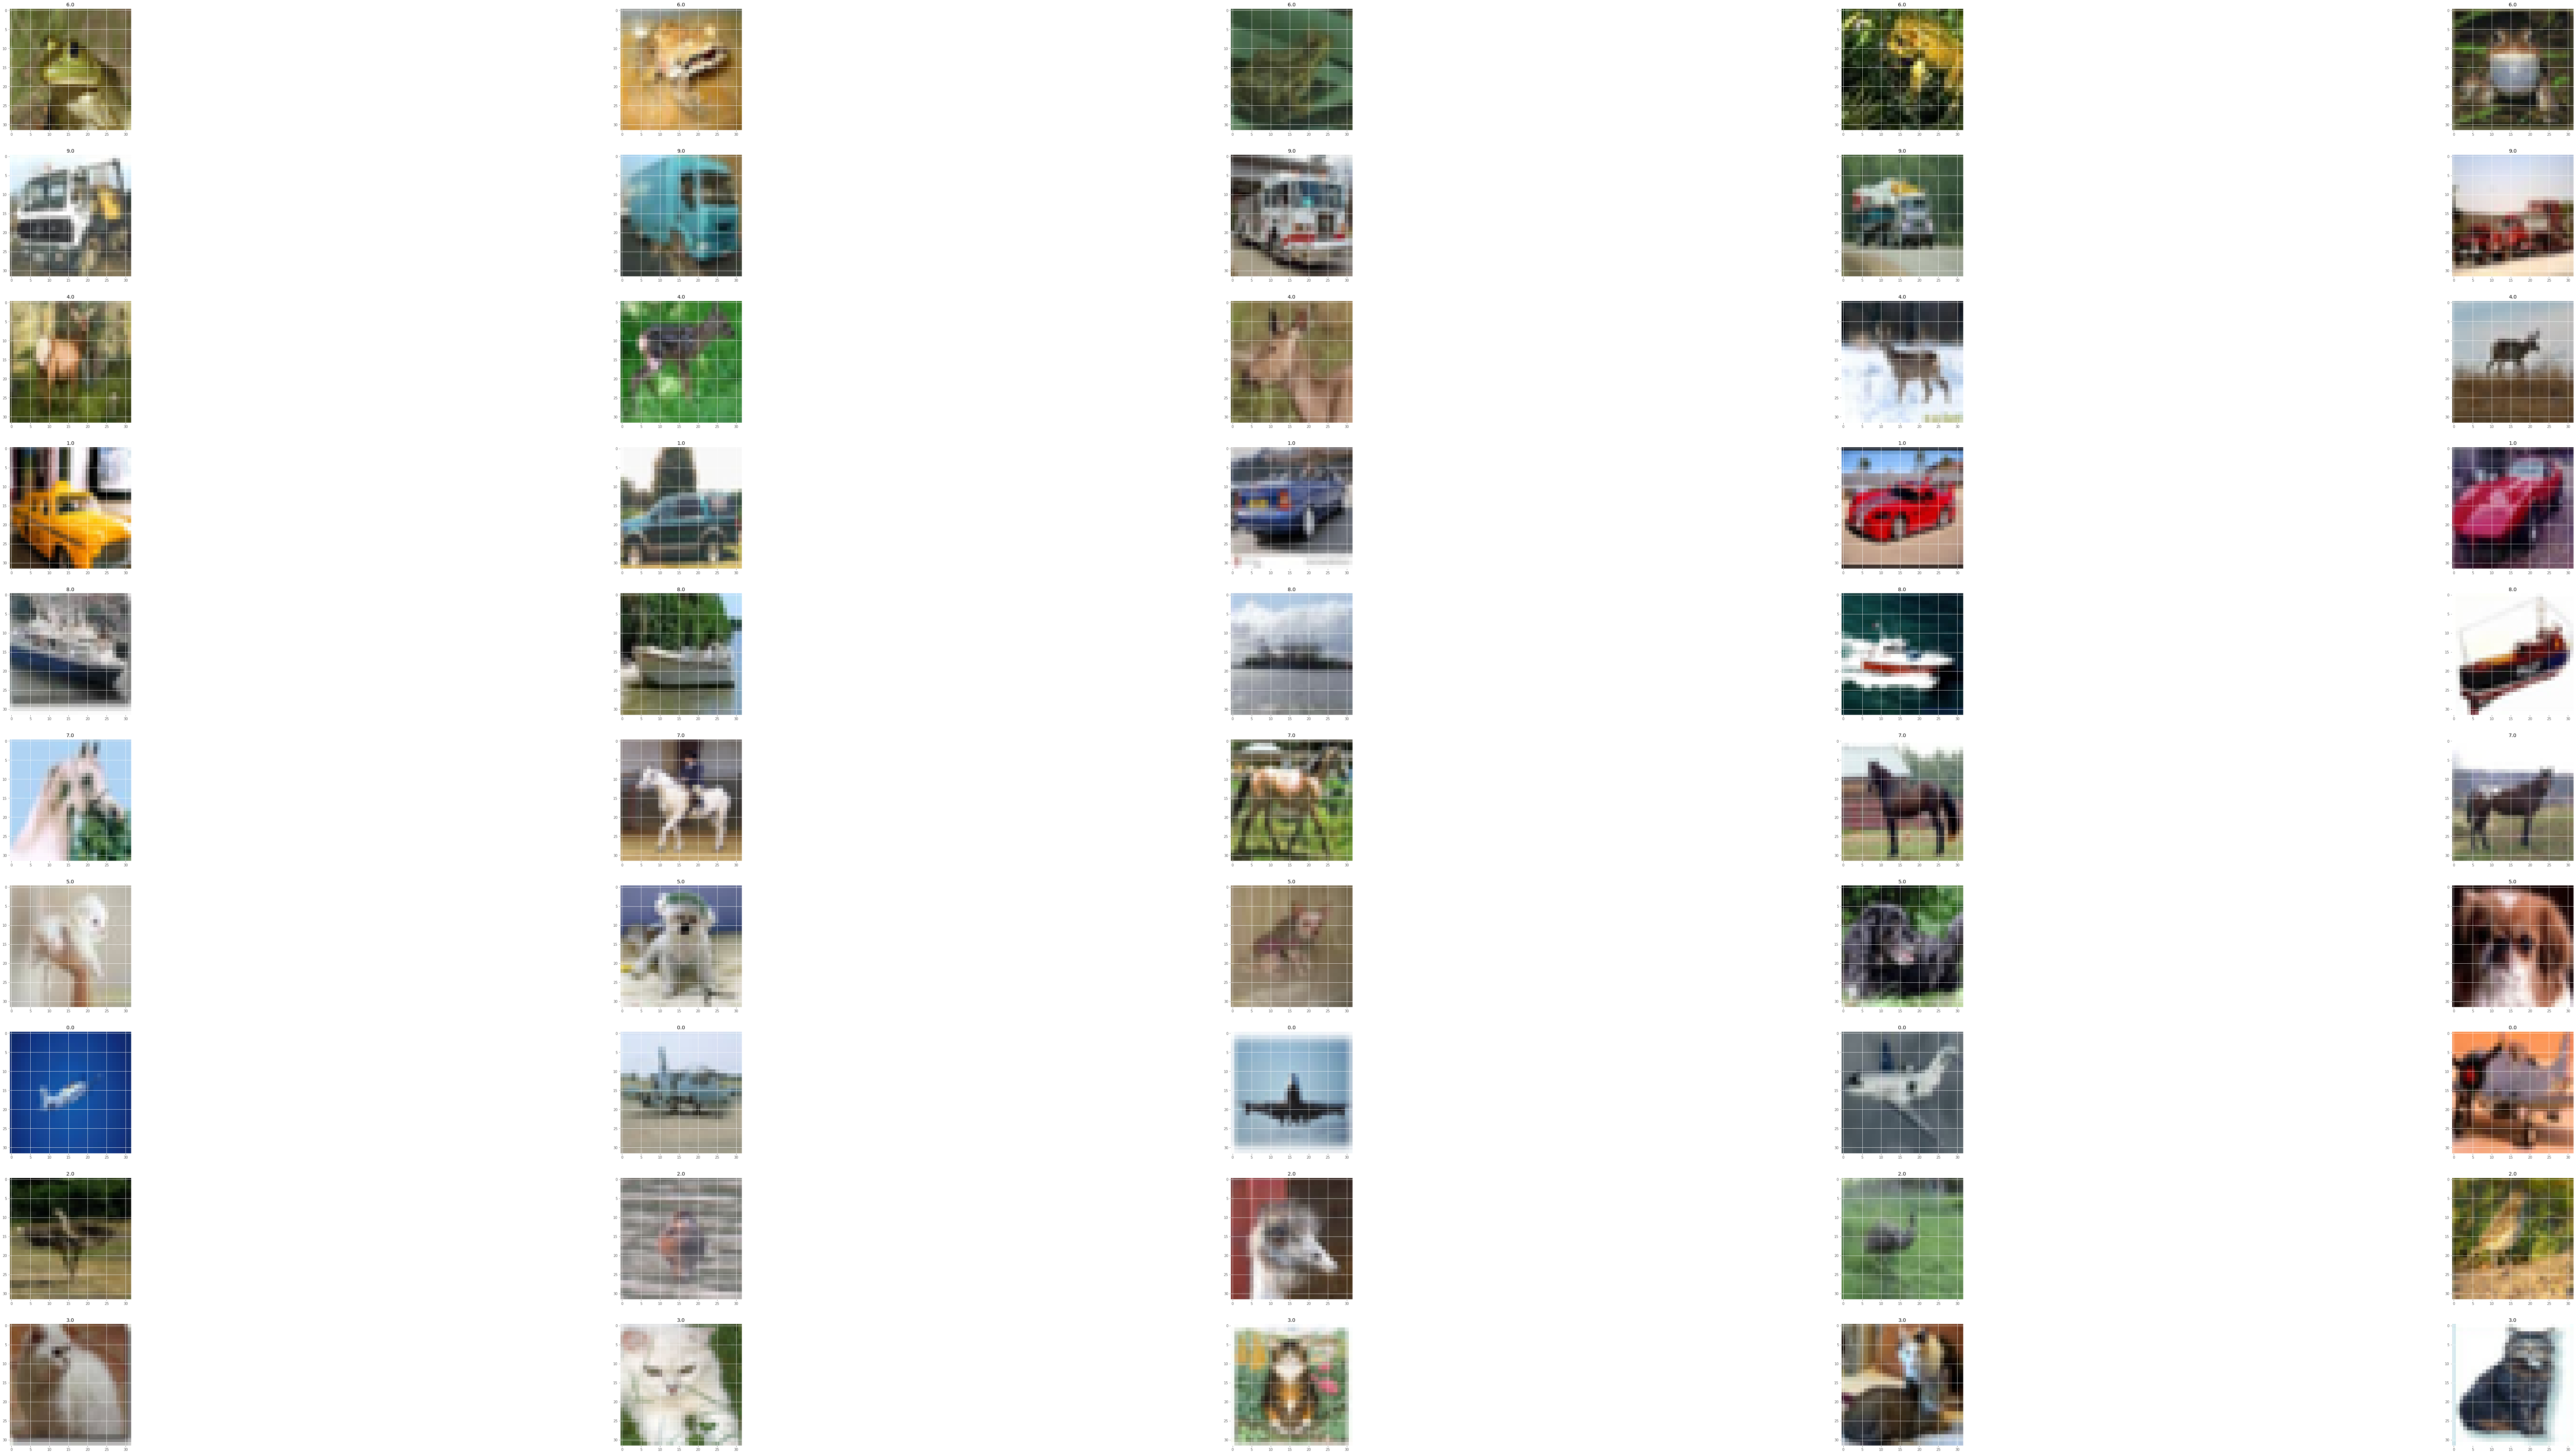

In [121]:
images = {}
for i in range(2500):
  if data['Y_train'][i] not in images.keys():
    images[data['Y_train'][i]] = []
  if len(images[data['Y_train'][i]]) < 5:
    images[data['Y_train'][i]].append(data['X_train'][i])
fig, axs = plt.subplots(10, 5)
fig.set_figheight(75)
fig.set_figwidth(150)
for i, key in enumerate(images.keys()):
  the_list = images[key]
  for j, value in enumerate(the_list):
    axs[i][j].imshow(value)
    axs[i][j].set_title(key)

In [122]:
data['X_train'] = data['X_train'].reshape(data['X_train'].shape[0], 32 * 32 * 3)
data['X_test'] = data['X_test'].reshape(data['X_test'].shape[0], 32 * 32 * 3)
data['X_val'] = data['X_val'].reshape(data['X_val'].shape[0], 32 * 32 * 3)
data['X_train'] = data['X_train'] / np.max(data['X_train'])
data['X_test'] = data['X_test'] / np.max(data['X_test'])
data['X_val'] = data['X_val'] / np.max(data['X_val'])
for k in data.keys():
    print(f'{k}: {data[k].shape}')

X_train: (2500, 3072)
Y_train: (2500,)
X_test: (1000, 3072)
Y_test: (1000,)
X_val: (500, 3072)
Y_val: (500,)


## Train and Test Model (25 Points)

### Batch Sampler
We need to sample bathces from our dataset to train model. Complete the following class to have a random sampler.

In [123]:
class RandomSampler(object):
    def __init__(self, batch_size, dataset, type):
        """
        Args:
            batch_size : sampler batch size
            dataset : dataset we want to get batch from that
            type : one of {'train', 'test', 'val'}
        """
        self.batch_size = batch_size
        self.dataset = dataset
        self.x_key = f'X_{type}'
        self.y_key = f'Y_{type}'
        self.indices = None
        the_list = []
        for i in range(self.dataset[self.x_key].shape[0]):
          the_list.append(i)
        to_sample = np.asarray(the_list)
        np.random.shuffle(to_sample)
        self.num_batches = self.dataset[self.x_key].shape[0] // self.batch_size
        final_list = []
        for i in range(self.num_batches):
          final_list.append(to_sample[self.batch_size * i: self.batch_size] * (i+1))
        self.indices = np.asarray(final_list)

    def __len__(self):
        assert type(self.num_batches) == int
        return self.num_batches

    def __iter__(self):
        """
        This function call when we iterate an object of this class and
        yields one batch on each call.

        Yields:
            (x, y) : tuple of bathces of x and y
        """
        for idx in self.indices:
            x = self.dataset[self.x_key][idx]
            y = self.dataset[self.y_key][idx]
            yield x, y


Fill the following functions to update a confusion matrix and calculate f1 score for a confusion matrix. For multi class f1 score read [here](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1).

In [124]:
def update_confusion_matrix(conf_matrix, preds, reals):
    """
    Updates confusion matrix

    Args:
        conf_matrix : input confusion matrix
        preds : array of predicted labels
        reals : array of real labels

    Returns:
        conf_matrix : updated confusion matrix
    """
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            real_rows = reals == i
            pred_cols = preds == j
            both_are_the_same = real_rows & pred_cols
            to_add = np.sum(both_are_the_same)
            conf_matrix[i, j] += to_add
    return conf_matrix


def f1_score(confusion_matrix):
    """
    calculate macro f1 score from given confusion matrix

    Args:
        confusion_matrix : given confusion matrix
        
    Returns:
        f1 : macro f1 score
    """
    f1_scores = []
    for i in range(confusion_matrix.shape[0]):
        precision = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i]) if np.sum(confusion_matrix[:, i]) != 0 else 0
        recall = confusion_matrix[i, i] / np.sum(confusion_matrix[i, :]) if np.sum(confusion_matrix[i, :]) != 0 else 0
        f1_scores.append(0 if precision + recall == 0 else 2 * recall * precision / (recall + precision))
    return np.mean(np.asarray(f1_scores))

### Define Model
Define an MLP model to solve classification problem.

In [125]:
model_initializer = lambda dim_in, dim_out: np.random.normal(0, np.sqrt(1 / ((dim_in + dim_out) / 2)), (dim_out, dim_in))
layers = [
    LinearLayer(32 * 32 * 3, 512, model_initializer, True, 0.01),
    ReLU(),
    LinearLayer(512, 128, model_initializer, True, 0.01),
    ReLU(),
    LinearLayer(128, 32, model_initializer, True, 0.01),
    ReLU(),
    LinearLayer(32, 10, model_initializer, True, 0.01),
    LogSoftMax()
]
model = MLPModel(layers)

In [126]:
n_epochs = 10
batch_size = 100
lr = 0.001
reg_coeff = 0.001

In [127]:
criterion = CrossEntropyLoss()
optimizer = Optimizer(model.get_parameters(), 'momentum', lr)
train_sampler = RandomSampler(batch_size, data, 'train')
val_sampler = RandomSampler(batch_size, data, 'val')
test_sampler = RandomSampler(batch_size, data, 'test')

<ipython-input-123-313d5b1e3a8a>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.indices = np.asarray(final_list)


### Train Model

Fill in the below cell to train the model. Store each epoch loss, accuracy and f1-score. Use f1-score to choose best epoch.

**Note1**: To do backpropagation you need to first call `backward` function of criterion with 1 as its argument to have gradient of loss w.r.t output of this module and then using model `backward` function with `criterion.grads['x']` argument.

**Note2**: You can ignore regularization term in your total loss value and just use criterion, but you must consider that during updating.

In [128]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_f1, val_f1 = [], []
best_model = None
best_f1 = 0

for epoch in range(n_epochs):
    total_loss = 0
    N = 0
    confusion = np.zeros((10, 10))
    with tqdm.tqdm(enumerate(train_sampler), total=len(train_sampler)) as pbar:
        for i, (x, y) in pbar:
            N += len(x)
            prediction = model(x)
            update_confusion_matrix(confusion, np.argmax(prediction, axis=1), y)
            total_loss += criterion(prediction, y)
            criterion.backward(1)
            model.backward(criterion.grads['x'])
            optimizer.step()
            pbar.set_description(f'Train {epoch} | Loss:{total_loss/N:.2e} | Acc: {0 if np.sum(confusion) == 0 else np.trace(confusion) / np.sum(confusion):.2f}| F1: {f1_score(confusion):.2f}|')
    
    # save epoch metrics for train phase
    train_losses.append(total_loss/N)
    train_accs.append(0 if np.sum(confusion) == 0 else np.trace(confusion) / np.sum(confusion))
    train_f1.append(f1_score(confusion))
    

    # Validation Phase
    total_loss = 0
    N = 0
    confusion = np.zeros((10, 10))
    with tqdm.tqdm(enumerate(val_sampler), total=len(val_sampler)) as pbar:
        for i, (x, y) in pbar:
            N += len(x)
            prediction = model(x)
            update_confusion_matrix(confusion, np.argmax(prediction, axis=1), y)
            total_loss += criterion(prediction, y)
            pbar.set_description(f'Val   {epoch} | Loss:{total_loss/N:.2e} | Acc: {0 if np.sum(confusion) == 0 else np.trace(confusion) / np.sum(confusion):.2f}| F1: {f1_score(confusion):.2f}|')
    
    # save epoch metrics for validation phase
    val_losses.append(total_loss/N)
    val_accs.append(0 if np.sum(confusion) == 0 else np.trace(confusion) / np.sum(confusion))
    val_f1.append(f1_score(confusion))
    
    
    if f1_score(confusion) >= min(val_f1):
        best_model = copy.deepcopy(model)
        best_f1 = f1_score(confusion)  
    print(f'----------------------------[Epoch{epoch+1} finished!]----------------------------')

Train 0 | Loss:2.49e+02 | Acc: 0.10| F1: 0.03|:   4%|▍         | 1/25 [00:01<00:32,  1.36s/it]/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
Train 0 | Loss:2.49e+02 | Acc: 0.10| F1: 0.03|: 100%|██████████| 25/25 [00:01<00:00, 13.14it/s]
  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-110-d68986499286>:9: RuntimeWarning: invalid value encountered in reduce
  return np.array(list(map(np.logaddexp.reduce, array))).reshape(array.shape[0])
Val   0 | Loss:nan | Acc: 0.11| F1: 0.02|: 100%|██████████| 5/5 [00:00<00:00, 26.07it/s]


----------------------------[Epoch1 finished!]----------------------------


Train 1 | Loss:nan | Acc: 0.07| F1: 0.01|: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]
Val   1 | Loss:nan | Acc: 0.11| F1: 0.02|: 100%|██████████| 5/5 [00:00<00:00, 23.38it/s]


----------------------------[Epoch2 finished!]----------------------------


Train 2 | Loss:nan | Acc: 0.07| F1: 0.01|: 100%|██████████| 25/25 [00:01<00:00, 13.15it/s]
Val   2 | Loss:nan | Acc: 0.11| F1: 0.02|: 100%|██████████| 5/5 [00:00<00:00, 28.06it/s]


----------------------------[Epoch3 finished!]----------------------------


Train 3 | Loss:nan | Acc: 0.07| F1: 0.01|: 100%|██████████| 25/25 [00:01<00:00, 13.60it/s]
Val   3 | Loss:nan | Acc: 0.11| F1: 0.02|: 100%|██████████| 5/5 [00:00<00:00, 26.88it/s]


----------------------------[Epoch4 finished!]----------------------------


Train 4 | Loss:nan | Acc: 0.07| F1: 0.01|: 100%|██████████| 25/25 [00:01<00:00, 13.97it/s]
Val   4 | Loss:nan | Acc: 0.11| F1: 0.02|: 100%|██████████| 5/5 [00:00<00:00, 28.45it/s]


----------------------------[Epoch5 finished!]----------------------------


Train 5 | Loss:nan | Acc: 0.07| F1: 0.01|: 100%|██████████| 25/25 [00:01<00:00, 13.90it/s]
Val   5 | Loss:nan | Acc: 0.11| F1: 0.02|: 100%|██████████| 5/5 [00:00<00:00, 26.58it/s]


----------------------------[Epoch6 finished!]----------------------------


Train 6 | Loss:nan | Acc: 0.07| F1: 0.01|: 100%|██████████| 25/25 [00:01<00:00, 13.62it/s]
Val   6 | Loss:nan | Acc: 0.11| F1: 0.02|: 100%|██████████| 5/5 [00:00<00:00, 26.99it/s]


----------------------------[Epoch7 finished!]----------------------------


Train 7 | Loss:nan | Acc: 0.07| F1: 0.01|: 100%|██████████| 25/25 [00:01<00:00, 13.26it/s]
Val   7 | Loss:nan | Acc: 0.11| F1: 0.02|: 100%|██████████| 5/5 [00:00<00:00, 24.94it/s]


----------------------------[Epoch8 finished!]----------------------------


Train 8 | Loss:nan | Acc: 0.07| F1: 0.01|: 100%|██████████| 25/25 [00:01<00:00, 13.66it/s]
Val   8 | Loss:nan | Acc: 0.11| F1: 0.02|: 100%|██████████| 5/5 [00:00<00:00,  9.78it/s]


----------------------------[Epoch9 finished!]----------------------------


Train 9 | Loss:nan | Acc: 0.07| F1: 0.01|: 100%|██████████| 25/25 [00:01<00:00, 13.69it/s]
Val   9 | Loss:nan | Acc: 0.11| F1: 0.02|: 100%|██████████| 5/5 [00:00<00:00, 26.23it/s]


----------------------------[Epoch10 finished!]----------------------------


### Test Model

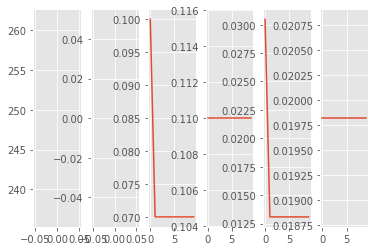

In [129]:
fig, axs = plt.subplots(1, 6)
axs[0].plot(np.arange(n_epochs), train_losses)
axs[1].plot(np.arange(n_epochs), val_losses)
axs[2].plot(np.arange(n_epochs), train_accs)
axs[3].plot(np.arange(n_epochs), val_accs)
axs[4].plot(np.arange(n_epochs), train_f1)
axs[5].plot(np.arange(n_epochs), val_f1)
plt.show()

<ipython-input-110-d68986499286>:9: RuntimeWarning: invalid value encountered in reduce
  return np.array(list(map(np.logaddexp.reduce, array))).reshape(array.shape[0])


loss: nan
f1 score: 0.01834695731153497


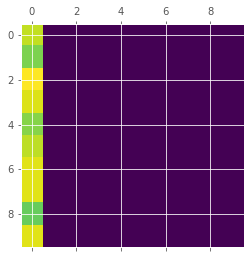

In [130]:
test_confusion = update_confusion_matrix(np.zeros((10, 10)), np.argmax(best_model(data['X_test']), axis=1), data['Y_test'])
print("loss:", criterion(best_model(data['X_test']), data['Y_test']) / len(data['Y_test']))
print("f1 score:", f1_score(test_confusion))
plt.matshow(test_confusion)
plt.show()

## Weights Visualization (5 Points)

For the last part we want to visualize weights matrix of the first layer.

In [131]:
##########################################################
##          Visualize n of first layer weights          ##
##          First reshape them to (32, 32, 3)           ##
##########################################################
n = 5